## Logistic Regression - Multiclass Classification

We will implement multiclass logistic regression and see how the outputs can be interpreted as probabilities across multiple classes. We will explore essential performance metrics and use optimised approach using `sklearn` on the Iris dataset.

In [1]:
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt; import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import label_binarize
import warnings; warnings.filterwarnings('ignore')

We'll use the classic Iris dataset with features such as sepal length, sepal width, petal length, and petal width.

The target feature has 3 classes: Setosa (0), Versicolor (1), and Virginica (2)

iris is a **Bunch object** (like a dictionary with extra attributes).

Contents of iris
- iris.data → feature values (150 × 4 array: sepal length, sepal width, petal length, petal width).
- iris.feature_names → names of the features (['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']).
- iris.target → numeric class labels (0, 1, 2).
- iris.target_names → names of the classes (['setosa', 'versicolor', 'virginica']).

In [3]:
# Load the Iris dataset
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target)

print(f'Input shape: {X.shape}')
print(f'Class distribution:')
for i, class_name in enumerate(iris.target_names):
    count = (y == i).sum()
    print(f'  {class_name}: {count} ({count/len(y):.1%})')

Input shape: (150, 4)
Class distribution:
  setosa: 50 (33.3%)
  versicolor: 50 (33.3%)
  virginica: 50 (33.3%)


The dataset is balanced with equal samples per class. The `train_test_split()` function splits arrays or matrices into random train and test subsets. We will stratify on the target feature. In case of multiple classes, this will keep the proportion of each class roughly the same in test and training sets.

If both train_size and test_size are given, then the remainder goes into a “discarded” split — it’s not returned as train or test.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, test_size=0.2, stratify=y, random_state=0)
print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")
print(f"Train class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

Train: 75, Test: 30
Train class distribution: [25 25 25]
Test class distribution: [10 10 10]


Let's train the model using `sklearn.LogisticRegression`. For multiclass problems, sklearn uses the **one-vs-rest** strategy by default, which trains one binary classifier per class. You can also use multinomial logistic regression (softmax based) by setting `multi_class='multinomial'`.

In [5]:
model = LogisticRegression(random_state = 0, multi_class='ovr')  # One-vs-Rest
model.fit(X_train, y_train)
print(f'Intercept: {model.intercept_}')
print(f'Coefficients shape: {model.coef_.shape} (3 classes, 4 features)')
print(f'Classes: {model.classes_}')

Intercept: [  5.80768862   5.64124778 -12.18688176]
Coefficients shape: (3, 4) (3 classes, 4 features)
Classes: [0 1 2]


For multiclass classification, sklearn trains separate binary classifiers for each class. The model outputs probabilities for each class through softmax, then converts to class predictions.

Let's see the probabilities and class predictions

In [6]:
y_proba = model.predict_proba(X_test) # Probabilities for all classes
y_pred = model.predict(X_test) # Predictions

# Create a results dataframe for first 5 samples
results_df = pd.DataFrame({'Actual': [iris.target_names[i] for i in y_test.iloc[:5].values], 'Prob_Setosa': y_proba[:5, 0], 
                           'Prob_Versicolor': y_proba[:5, 1], 'Prob_Virginica': y_proba[:5, 2], 'Prediction': [iris.target_names[i] for i in y_pred[:5]]}).round(3)
print(results_df)

       Actual  Prob_Setosa  Prob_Versicolor  Prob_Virginica  Prediction
0  versicolor        0.003            0.348           0.649   virginica
1  versicolor        0.027            0.609           0.363  versicolor
2  versicolor        0.036            0.851           0.114  versicolor
3      setosa        0.852            0.148           0.000      setosa
4      setosa        0.863            0.137           0.000      setosa


Let's first check the log loss on both training and testing sets

In [7]:
test_log_loss = log_loss(y_test, y_proba)
print(f'Log Loss (Test): {test_log_loss:.3f}')

y_proba_train = model.predict_proba(X_train) 
y_pred_train = model.predict(X_train) 
train_log_loss = log_loss(y_train, y_proba_train)
print(f'Log Loss (Train): {train_log_loss:.3f}')

Log Loss (Test): 0.300
Log Loss (Train): 0.314


A lower log loss indicates better performance. The test loss is slightly higher than the train loss, meaning low overfitting.

### Evaluation
Let's compare the confusion matrices for training and testing and see how classification and misclassification counts look like for all three classes

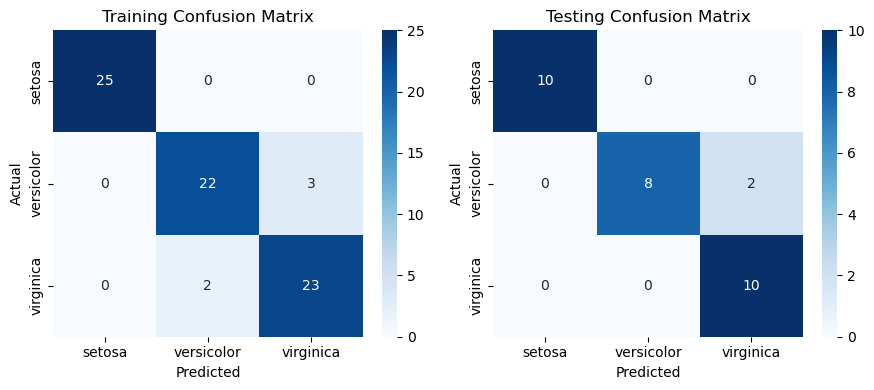

In [8]:
cm_train = confusion_matrix(y_train, y_pred_train) # Train confusion matrix
cm_test = confusion_matrix(y_test, y_pred) # Test confusion matrix

fig, axes = plt.subplots(1, 2, figsize = (9, 4))
sns.heatmap(cm_train, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = iris.target_names, yticklabels = iris.target_names, ax = axes[0])
axes[0].set_title('Training Confusion Matrix')
axes[0].set_ylabel('Actual'); axes[0].set_xlabel('Predicted')

sns.heatmap(cm_test, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = iris.target_names, yticklabels = iris.target_names, ax = axes[1])
axes[1].set_title('Testing Confusion Matrix')
axes[1].set_ylabel('Actual'); axes[1].set_xlabel('Predicted')
plt.tight_layout()

We can see that the confusion matrices are consistent between train and test sets, suggesting good generalisation

For multiclass classification, we usually calculate precision, recall etc. for all classes, and then take various averages for them. Let's look at the multiclass metrics.

In [9]:
accuracy = accuracy_score(y_test, y_pred)

# For multiclass, we can compute macro, micro, and weighted averages
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_micro = precision_score(y_test, y_pred, average='micro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')

recall_macro = recall_score(y_test, y_pred, average='macro')
recall_micro = recall_score(y_test, y_pred, average='micro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')

f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.3f}')
print('\nPrecision:')
print(f'  Macro avg: {precision_macro:.3f} (unweighted mean across classes)')
print(f'  Micro avg: {precision_micro:.3f} (global across all samples)')
print(f'  Weighted avg: {precision_weighted:.3f} (weighted by class support)')
print('\nRecall:')
print(f'  Macro avg: {recall_macro:.3f} (unweighted mean across classes)')
print(f'  Micro avg: {recall_micro:.3f} (global across all samples)')
print(f'  Weighted avg: {recall_weighted:.3f} (weighted by class support)')
print('\nF1-Score:')
print(f'  Macro avg: {f1_macro:.3f} (unweighted mean across classes)')
print(f'  Micro avg: {f1_micro:.3f} (global across all samples)')
print(f'  Weighted avg: {f1_weighted:.3f} (weighted by class support)')

Accuracy: 0.933

Precision:
  Macro avg: 0.944 (unweighted mean across classes)
  Micro avg: 0.933 (global across all samples)
  Weighted avg: 0.944 (weighted by class support)

Recall:
  Macro avg: 0.933 (unweighted mean across classes)
  Micro avg: 0.933 (global across all samples)
  Weighted avg: 0.933 (weighted by class support)

F1-Score:
  Macro avg: 0.933 (unweighted mean across classes)
  Micro avg: 0.933 (global across all samples)
  Weighted avg: 0.933 (weighted by class support)


We can also print an overall classification report for the multiclass model

In [10]:
print(classification_report(y_test, y_pred, target_names = iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.80      0.89        10
   virginica       0.83      1.00      0.91        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



For multiclass classification, we can create precision-recall curves for each class using the one-vs-rest approach

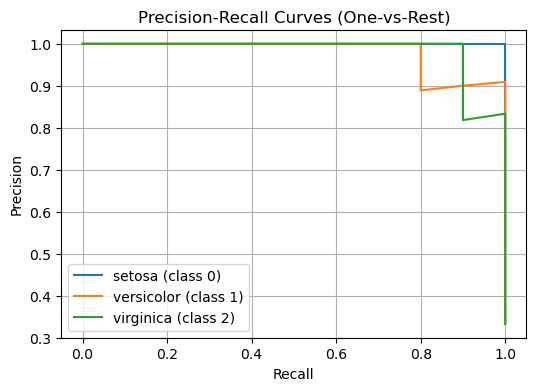

In [11]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]
plt.figure(figsize=(6,4))

for i in range(n_classes):  # PR curve for each class
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    plt.plot(recall, precision, label=f'{iris.target_names[i]} (class {i})')

plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curves (One-vs-Rest)')
plt.legend(); plt.grid(True)

Similarly, we can create ROC curves for each class using the one-vs-rest approach

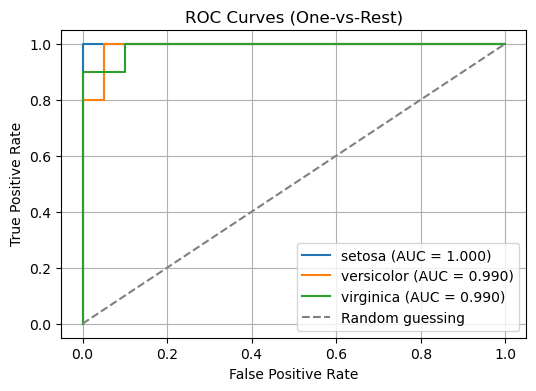

In [12]:
plt.figure(figsize=(6,4))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = roc_auc_score(y_test_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, label=f'{iris.target_names[i]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guessing')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)'); plt.legend(); plt.grid(True)

Let's also look at per-class metrics individually

In [13]:
# Calculate per-class metrics
precision_per_class = precision_score(y_test, y_pred, average=None)
recall_per_class = recall_score(y_test, y_pred, average=None)
f1_per_class = f1_score(y_test, y_pred, average=None)

print('Per-class Metrics:')
print('Class\t\tPrecision\tRecall\t\tF1-Score')
print('-' * 50)
for i, class_name in enumerate(iris.target_names):
    print(f'{class_name}\t\t{precision_per_class[i]:.3f}\t\t{recall_per_class[i]:.3f}\t\t{f1_per_class[i]:.3f}')

Per-class Metrics:
Class		Precision	Recall		F1-Score
--------------------------------------------------
setosa		1.000		1.000		1.000
versicolor		1.000		0.800		0.889
virginica		0.833		1.000		0.909


This demonstrates how multiclass logistic regression creates decision boundaries to separate the three classes. Each region corresponds to where one class has the highest predicted probability.

The Iris dataset was relatively simple and well-separated, making it ideal for demonstrating multiclass logistic regression